<a href="https://colab.research.google.com/github/akhilalfonsk/schedulecreator/blob/master/DublinBusTripDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import auth
auth.authenticate_user()
print('User Authenticated')
project_id = 'causefinder'
%load_ext google.colab.data_table

User Authenticated
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [17]:
%%bigquery --project causefinder
SELECT 
  COUNT(*) as total_tripdata
FROM `causefinder.TripDB.RealTimeTripData`

,total_tripdata
0,22783753


In [0]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

rawData = client.query('''
  SELECT
    *
  FROM
    `causefinder.TripDB.RealTimeTripData`''').to_dataframe()

## **Take Data Only When needed**

In [62]:
import numpy as np
import seaborn as sns
sns.set(style='white')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
df=rawData.copy(deep=True)
df.head(10)

,id,RouteNumber,ResponseTimestamp,DataScrapedTimestamp,OperetorRef,BlockRef,VehicleRef,JourneyRef,VehicleDirection,LineRef,DestinationStopId,BusStopId,VisitSequenceNumber,RecordedArrivalTime,AimedArrivalTime,AimedDepartureTime,ExpectedArrivalTime,ExpectedDepartureTime,InCongestionIndicator,AimedMinutesDue,ExpectedMinutesDue,RouteSequence,BusStopAddress,Latitude,Longitude
0,32718331,1,2019-02-27 19:58:47+00:00,2019-02-27 19:58:47+00:00,bac,1010,43105,4404,Outbound,1.0,52,46,16,2019-02-27 19:58:47+00:00,2019-02-27 20:11:57+00:00,2019-02-27 20:11:57+00:00,2019-02-27 20:11:57+00:00,2019-02-27 20:11:57+00:00,0,13,13,15,Drumcondra Rd,53.367147,-6.255359
1,5809640,1,2019-02-09 13:10:27+00:00,2019-02-09 13:10:27+00:00,bac,1001,44093,10288,Outbound,1.0,49,46,16,2019-02-09 13:10:27+00:00,2019-02-09 13:33:59+00:00,2019-02-09 13:33:59+00:00,2019-02-09 13:33:59+00:00,2019-02-09 13:33:59+00:00,0,23,23,15,Drumcondra Rd,53.367147,-6.255359
2,17156097,1,2019-02-16 23:29:37+00:00,2019-02-16 23:29:37+00:00,bac,1005,44210,10353,Outbound,1.0,271,46,16,2019-02-16 23:29:37+00:00,2019-02-16 23:37:41+00:00,2019-02-16 23:37:41+00:00,2019-02-16 23:37:41+00:00,2019-02-16 23:37:41+00:00,0,8,8,15,Drumcondra Rd,53.367147,-6.255359
3,21790438,1,2019-02-19 23:39:29+00:00,2019-02-19 23:39:29+00:00,bac,1014,44086,4455,Outbound,1.0,271,46,16,2019-02-19 23:39:29+00:00,2019-02-19 23:37:48+00:00,2019-02-19 23:37:48+00:00,2019-02-19 23:41:07+00:00,2019-02-19 23:41:07+00:00,0,-1,1,15,Drumcondra Rd,53.367147,-6.255359
4,27338966,1,2019-02-23 23:27:27+00:00,2019-02-23 23:27:27+00:00,bac,1005,44092,10353,Outbound,1.0,271,46,16,2019-02-23 23:27:27+00:00,2019-02-23 23:37:41+00:00,2019-02-23 23:37:41+00:00,2019-02-23 23:37:41+00:00,2019-02-23 23:37:41+00:00,0,10,10,15,Drumcondra Rd,53.367147,-6.255359
5,32898576,11,2019-02-27 22:54:56+00:00,2019-02-27 22:54:56+00:00,bac,11009,43089,6593,Outbound,11.0,271,48,16,2019-02-27 22:54:56+00:00,2019-02-27 23:39:53+00:00,2019-02-27 23:39:53+00:00,2019-02-27 23:39:53+00:00,2019-02-27 23:39:53+00:00,0,44,44,15,Drumcondra Rd,53.362322,-6.258764
6,20210699,11,2019-02-18 23:21:55+00:00,2019-02-18 23:21:55+00:00,bac,11009,33538,6613,Outbound,11.0,271,48,16,2019-02-18 23:21:55+00:00,2019-02-18 23:37:45+00:00,2019-02-18 23:37:45+00:00,2019-02-18 23:37:45+00:00,2019-02-18 23:37:45+00:00,0,15,15,15,Drumcondra Rd,53.362322,-6.258764
7,20192454,11,2019-02-18 23:06:11+00:00,2019-02-18 23:06:11+00:00,bac,11009,33538,6613,Outbound,11.0,271,48,16,2019-02-18 23:06:11+00:00,2019-02-18 23:37:45+00:00,2019-02-18 23:37:45+00:00,2019-02-18 23:37:45+00:00,2019-02-18 23:37:45+00:00,0,31,31,15,Drumcondra Rd,53.362322,-6.258764
8,11248405,11,2019-02-12 23:16:12+00:00,2019-02-12 23:16:12+00:00,bac,11009,38031,6613,Outbound,11.0,271,48,16,2019-02-12 23:16:12+00:00,2019-02-12 23:38:03+00:00,2019-02-12 23:38:03+00:00,2019-02-12 23:38:03+00:00,2019-02-12 23:38:03+00:00,0,21,21,15,Drumcondra Rd,53.362322,-6.258764
9,31543762,11,2019-02-26 23:09:07+00:00,2019-02-26 23:09:07+00:00,bac,11009,44475,6593,Outbound,11.0,271,48,16,2019-02-26 23:09:07+00:00,2019-02-26 23:39:53+00:00,2019-02-26 23:39:53+00:00,2019-02-26 23:39:53+00:00,2019-02-26 23:39:53+00:00,0,30,30,15,Drumcondra Rd,53.362322,-6.258764


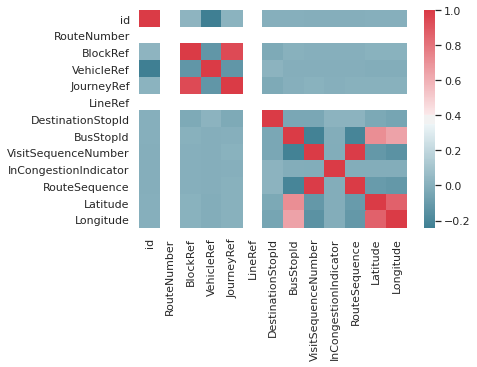

In [50]:
sns.heatmap(df.corr(),cmap=cmap)

In [0]:
df = df.drop(['id','ResponseTimestamp','DataScrapedTimestamp','OperetorRef','LineRef','AimedDepartureTime','ExpectedArrivalTime','ExpectedDepartureTime','ExpectedMinutesDue'], axis=1)

In [0]:
def LabelEncoding(col):
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  le.fit(df[col])
  list(le.classes_)
  return le.transform(df[col])

In [0]:

df['BlockRefNew']=LabelEncoding('BlockRef')
df['VehicleRefNew']=LabelEncoding('VehicleRef')
df['JourneyRefNew']= LabelEncoding('JourneyRef')
df['VehicleDirectionNew']= LabelEncoding('VehicleDirection')
df['DestinationStopIdNew']= LabelEncoding('DestinationStopId')
df['BusStopIdNew']= LabelEncoding('BusStopId')
df['BusStopAddressNew'] = LabelEncoding('BusStopAddress')

In [0]:
df['Weekday']= df['RecordedArrivalTime'].dt.weekday
df['AimedMinutesDueUpdated'] = (df['RecordedArrivalTime']-df['AimedArrivalTime']).astype('timedelta64[m]')

In [55]:
import pandas as pd
df['HourOfDay']=df['RecordedArrivalTime'].dt.hour
#df['WeeklyHourOfDay']=df['RecordedArrivalTime'].dt.hour*df['RecordedArrivalTime'].dt.weekday
print(df.dtypes)

RouteNumber                             int64
BlockRef                                int64
VehicleRef                              int64
JourneyRef                              int64
VehicleDirection                       object
DestinationStopId                       int64
BusStopId                               int64
VisitSequenceNumber                     int64
RecordedArrivalTime       datetime64[ns, UTC]
AimedArrivalTime          datetime64[ns, UTC]
InCongestionIndicator                   int64
AimedMinutesDue                        object
RouteSequence                           int64
BusStopAddress                         object
Latitude                              float64
Longitude                             float64
BlockRefNew                             int64
VehicleRefNew                           int64
JourneyRefNew                           int64
VehicleDirectionNew                     int64
DestinationStopIdNew                    int64
BusStopIdNew                      

In [0]:
df['LogLat']=df['Longitude']*df['Latitude'].astype(int)
df['Week_of_the_month']= ((df['RecordedArrivalTime'].dt.day + (df['RecordedArrivalTime'].dt.weekday)) / 6);
df['Week_of_the_month'] =  np.trunc(df['Week_of_the_month']).astype(int)
df['AimedMinutesDue'] = pd.to_numeric(df['AimedMinutesDue'], downcast='integer')
df['AimedMinutesDueUpdated'] = pd.to_numeric(df['AimedMinutesDueUpdated'], downcast='integer')

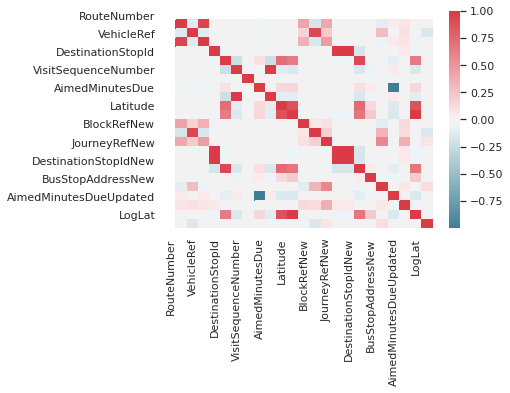

In [43]:
sns.heatmap(df.corr(),cmap=cmap)

In [0]:
df = df.drop(['RecordedArrivalTime','BlockRef','VehicleRef','JourneyRef',
              'BusStopId','DestinationStopId','VehicleDirection','BusStopAddress',
              'RouteSequence','Week_of_the_month','InCongestionIndicator','RouteNumber',
              'DestinationStopIdNew','Hour_of_the_day','Longitude','Latitude','AimedArrivalTime','AimedMinutesDue','LogLat'],axis =1, errors='ignore')

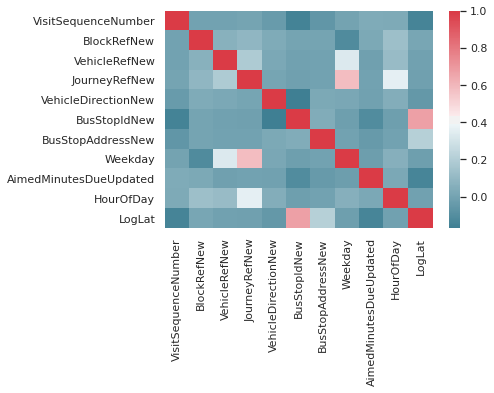

In [58]:
sns.heatmap(df.corr(),cmap=cmap)

In [0]:
# df["visithr"]=df["Hour_of_the_day_new"]*df["VisitSequenceNumber"]
# df["vehiwkday"]=df["Hour_of_the_day_new"]*df["Weekday"]
# df=df.drop(["Hour_of_the_day_new","VisitSequenceNumber","Weekday"],axis =1)

In [59]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('AimedMinutesDueUpdated', axis=1), df['AimedMinutesDueUpdated'], test_size=0.2, random_state=42)
print(df.dtypes)
train_x.shape

VisitSequenceNumber         int64
BlockRefNew                 int64
VehicleRefNew               int64
JourneyRefNew               int64
VehicleDirectionNew         int64
BusStopIdNew                int64
BusStopAddressNew           int64
Weekday                     int64
AimedMinutesDueUpdated       int8
HourOfDay                   int64
LogLat                    float64
dtype: object


(1090576, 10)

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

regressor = LinearRegression(fit_intercept=True,normalize=True, copy_X=True)  
regressor.fit(train_x, train_y)
y_pred = regressor.predict(test_x)
regressor.score(test_x,test_y)


0.022187117352293617

In [0]:
df.

In [0]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.001, epsilon=1)
svr_rbf.fit(train_x, train_y)
svr_rbf.score(test_x,test_y)

In [0]:
df.

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

model = linear_model.LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_search = GridSearchCV(model,parameters, cv=None)
grid_search.fit(train_x, train_y)
pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

In [0]:
from sklearn.svm import SVR
from sklearn.svm import SVC
# from sklearn.metrics import make_scorer
# scorer = make_scorer(mean_squared_error, greater_is_better=False)
# svr_gs = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = K, scoring=scorer)

# def svc_param_selection(X, y, nfolds):
param_grid = {'C': [0.001, 0.01, 10, 100], 'gamma' : [0.001, 0.01, 0.1, 0.001]}
grid_search = GridSearchCV(SVR(epsilon = 0.01), param_grid, cv = 5)
grid_search.fit(train_x, train_y)
pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

# svr_rbf = SVR(kernel='rbf', C=100, gamma=0.001, epsilon=1)
# svr_rbf = SVR(svc_param_selection(train_x,train_y,5))
# svr_rbf.fit(train_x, train_y)
# svr_rbf.score(test_x,test_y)

In [0]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(train_x,train_y)
preds_y = xg_reg.predict(test_x)
rmse = np.sqrt(mean_squared_error(test_y, preds_y))
print(xg_reg.score(test_x,test_y))

In [0]:
from sklearn.linear_model import BayesianRidge
clf = BayesianRidge(compute_score=True)
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)
clf.score(test_x,test_y)

In [0]:
from sklearn.preprocessing import PolynomialFeatures 
  
poly = PolynomialFeatures(degree = 4) 
X_poly = poly.fit_transform(X) 
  
poly.fit(X_poly, y) 
lin2 = LinearRegression() 
lin2.fit(X_poly, y)

In [0]:
import matplotlib.pyplot as plt
plt.plot(test_y, y_pred, color='gold',
         label="Ground Truth")
plt.ylabel("Output y")
plt.xlabel("Feature X")
plt.legend(loc="lower left")
plt.show()